In [44]:
import glob
import numpy as np
import glob, os, json
import matplotlib.pyplot as plt
from scipy.interpolate import interp2d, interp1d
from jwst import *

%load_ext autoreload
%autoreload 2

For Bex Files, 

First # corresponds to atmospheric grid, -2 for petitCODE, -3 for HELIOS

Then metallicity M/H is given

If clouds, fsed is given

Then earth masses at the end (ME)

In [40]:
bex_dir = "/Users/maxwellmb/Data/models/BEX/isochrones/"
filename = "BEX_evol_mags_-2_MH_0.00.dat"

bex_file = '/Users/maxwellmb/Data/models/BEX/isochrones/BEX_evol_mags_-2_MH_0.00AC.dat'
bex_filter = 'f444w'

# bex_data = np.genfromtxt(bex_dir+filename).transpose()

with open(bex_file, 'r') as f:
    bex_data = json.load(f)
bex_ages = 10**np.array(bex_data['log(age/yr)']) / 1e6     # In Myr
bex_masses = np.array(bex_data['mass/mearth']) / 317.8       #In MJup
bex_abs_mags = bex_mags = np.array(bex_data[bex_filter])


In [45]:
np.max(bex_ages)

3981.071705534969

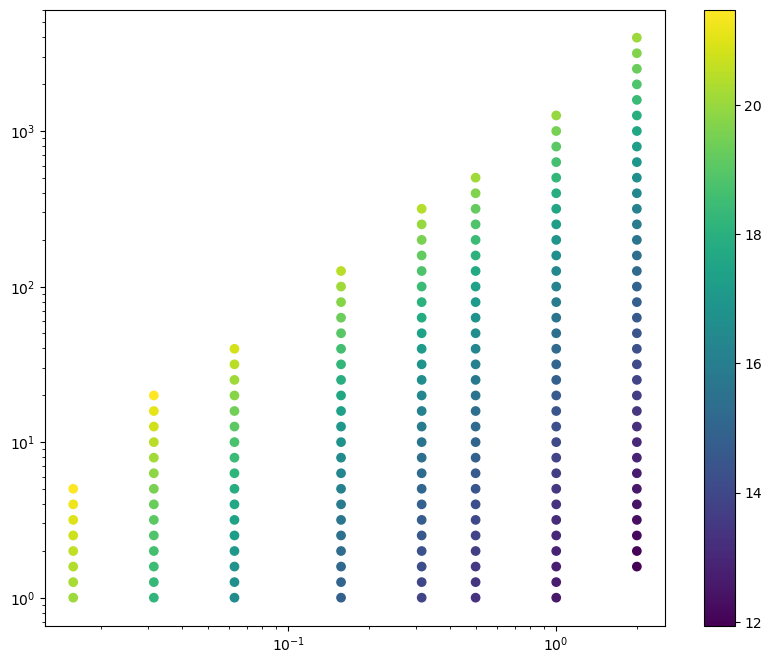

In [41]:
fig,axis = plt.subplots(1,1,figsize=(10,8))

plt.scatter(bex_masses,bex_ages,c=bex_abs_mags)
axis.set_xscale("log")
axis.set_yscale("log")
plt.colorbar()

In [31]:
input_age = 57

bex_ages_nodups = list(dict.fromkeys(bex_ages))
bex_ages_diff = [abs(x-input_age) for x in bex_ages_nodups]
bex_masses_nodups =  list(dict.fromkeys(bex_masses))

if min(bex_ages_diff) == 0:
	#Exact age in grid, less interpolation needed.
	closest_age = bex_ages_nodups[bex_ages_diff.index(np.min(bex_ages_diff))]
	closest_ages = [closest_age, closest_age]
else:
	#Need two points of interpolation
	min_diffs_index = [bex_ages_diff.index(x) for x in np.partition(bex_ages_diff, 1)[0:2]]
	closest_ages = [bex_ages_nodups[x] for x in min_diffs_index]

common_masses = set(bex_masses[np.where(bex_ages == closest_ages[0])]).intersection(bex_masses[np.where(bex_ages == closest_ages[1])])
common_masses = list(sorted(common_masses))   #The ones we want to keep
cut_masses = list(set(bex_masses_nodups) - set(common_masses))

for bex_age in bex_ages:
	row_indexes = np.where(bex_ages==bex_age)
	age_masses = bex_masses[row_indexes]
	if len(age_masses) < len(common_masses): #Number of masses too small, cut this age
		bex_ages = np.delete(bex_ages, row_indexes)
		bex_masses = np.delete(bex_masses, row_indexes)
		bex_mags = np.delete(bex_mags, row_indexes)	
	elif len(age_masses) == len(common_masses): 
		if not np.array_equal(age_masses,common_masses): #Number of masses correct, but does not match common_masses, so not enough
			bex_ages = np.delete(bex_ages, row_indexes)
			bex_masses = np.delete(bex_masses, row_indexes)
			bex_mags = np.delete(bex_mags, row_indexes)
		else: #Number of masses must be correct and match
			continue
	else: #Number of masses too large, must trim
		for age_mass in age_masses:
			row_index = row_indexes[0][np.where(age_masses==age_mass)[0][0]]   #Indexing quite specific here as using np arrays
			if age_mass not in common_masses:
				bex_ages = np.delete(bex_ages, row_index)
				bex_masses = np.delete(bex_masses, row_index)
				bex_mags = np.delete(bex_mags, row_index)

# Remake non-duplicate arrays with new trimmed grid
bex_ages_nodups = list(dict.fromkeys(bex_ages))
bex_masses_nodups =  list(dict.fromkeys(bex_masses))

#Make magnitude array 2D with dimensions len(age), len(masses)
bex_mags = np.reshape(bex_mags, (len(bex_ages_nodups), len(bex_masses_nodups))).transpose()

x = np.array(bex_ages_nodups)
y = np.array(bex_masses_nodups)
z = np.array(bex_mags)

agemass_interp = interp2d(x, y, z, kind='cubic')

mag_interp = agemass_interp([input_age]*len(bex_masses_nodups), bex_masses_nodups)
mag_interp = [x[0] for x in mag_interp]

mass_interp = interp1d(mag_interp, bex_masses_nodups, kind='slinear', bounds_error=False, fill_value=np.nan)

In [42]:
mag_interp

[18.30670956109313,
 16.540969720555914,
 16.77441739862041,
 16.804803775281368,
 15.22314037276887]

In [43]:
mass_interp

Now this is all converted into a function 'get_mass_func_from_mag_bex' in models.py